In [56]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [57]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [58]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [59]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [60]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [61]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [62]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [63]:
# Create our session (link) from Python to the DB
session_link = Session(engine)

# Exploratory Precipitation Analysis

In [64]:
# Find the most recent date in the data set.
recent_date = session_link.query(func.max(Measurement.date)).scalar()
print(f"Most recent date: {recent_date}")

Most recent date: 2017-08-23


Most recent date: 2017-08-23
Date one year ago: 2016-08-23 00:00:00


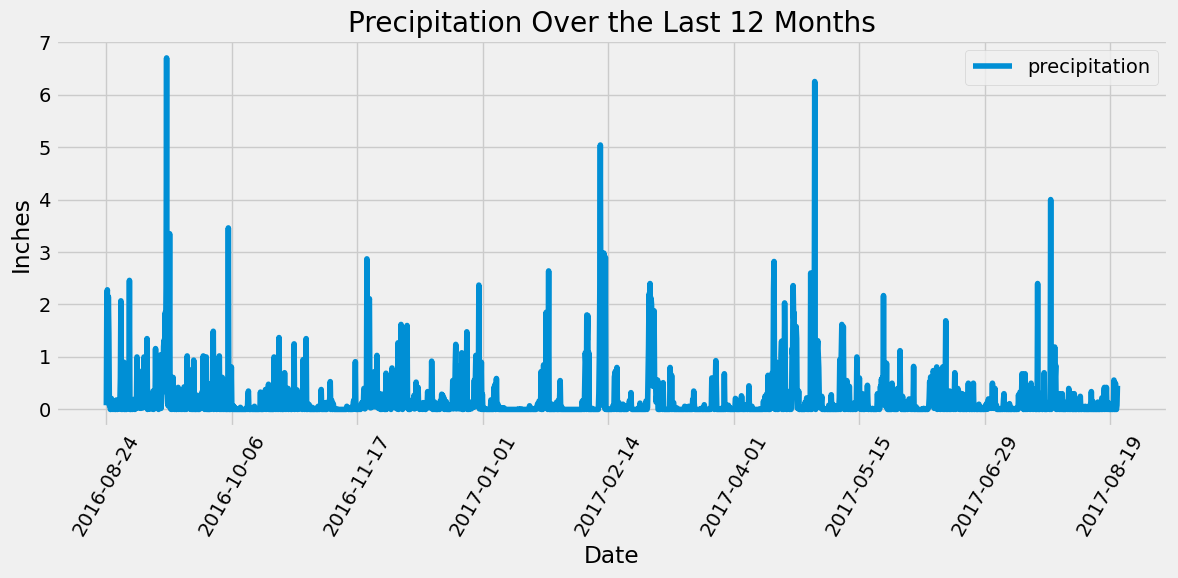

In [65]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = session_link.query(func.max(Measurement.date)).scalar()
print(f"Most recent date: {recent_date}")

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(recent_date, "%Y-%m-%d") - dt.timedelta(days=365)
print(f"Date one year ago: {one_year_ago}")

# Perform a query to retrieve the data and precipitation scores
results = session_link.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago)\
    .order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(results, columns=["Date", "Precipitation"])

# Drop rows with missing precipitation data
precip_df.dropna(inplace=True)

# Sort the dataframe by date
precip_df.set_index("Date", inplace=True)
precip_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(
    figsize=(12, 6), 
    legend=True
)
plt.title("Precipitation Over the Last 12 Months")
plt.ylabel("Inches")
plt.xlabel("Date")
plt.legend(["precipitation"])
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

In [66]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_summary = precip_df.describe()
print(precip_summary)

       Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [67]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session_link.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [68]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations = session_link.query(Measurement.station, func.count(Measurement.id))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.id).desc())\
    .all()
print("Most active stations:")
for station, count in active_stations:
    print(station, count)

Most active stations:
USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [69]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations[0][0]

temp_stats = session_link.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).all()

min_temp, max_temp, avg_temp = temp_stats[0]
print({min_temp, max_temp, avg_temp})

{85.0, 54.0, 71.66378066378067}


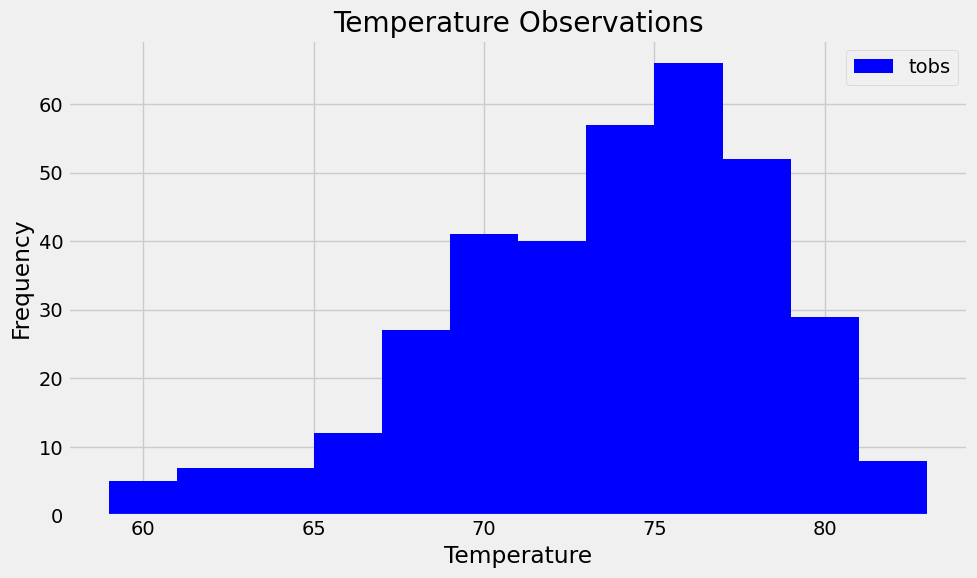

In [70]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperature_data = session_link.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station_id)\
    .filter(Measurement.date >= one_year_ago)\
    .all()

temperature_df = pd.DataFrame(temperature_data, columns=["tobs"])

temperature_df.plot.hist(
    bins=12, 
    figsize=(10, 6), 
    color="blue",  
    legend=True
)

plt.title("Temperature Observations")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Close Session

In [71]:
# Close Session
session_link.close()